# Synthetic Data Generator 

# Prompt to create faker code

Rol: Actúa como un experto en Ingeniería de Datos y Ciencia de Datos especializado en Retail Analytics.

Herramienta principal: Libreria Faker de Python

Tarea: Generar un dataset sintético en Python (usando Pandas, Numpy y Faker) para un modelo de Elasticidad de Precio.

Estructura de la Tabla:

sku, item, anio_sem (YYYYWW), so_volume, si_volume, si_unit_price, so_unit_price, promo_flag, holiday_flag.

Parámetros de Configuración (Variables):

Escala: N SKUs y W semanas (mínimo 56).

Lags de Precio: Aplicar un desfase de [1 a 2] semanas entre el cambio en si_unit_price y su reflejo en so_unit_price.

Elasticidad: Definir una relación inversamente proporcional entre so_unit_price y so_volume.

Estacionalidad: Configurar multiplicadores de volumen para:

Navidad: (Semanas 50-52) con efecto positivo.

Semana Santa: (Semana 12-14) con efecto negativo/positivo según categoría.

Categorización: Dividir los SKUs en grupos (ej. "Sensible a fechas", "Estable", "Premium") para que no todos reaccionen igual.

Lógica de Negocio Requerida:

El si_unit_price debe disparar el promo_flag.

El so_volume debe incluir un componente de "ruido blanco" (Gaussian noise) para simular variaciones reales de mercado.

Asegurar coherencia: el Sell Out Price siempre debe ser mayor al Sell In Price (margen).


**Translation**

Role: Act as a Data Engineering and Data Science expert specializing in Retail Analytics.

Task: Generate a synthetic dataset in Python (using Pandas, NumPy and Faker) for a Price Elasticity model.

Primary tool: Faker library for Python

Table Structure:

sku, item, year_week (YYYYWW), so_volume, si_volume, si_unit_price, so_unit_price, promo_flag, holiday_flag.

Configuration Parameters (Variables):

Scale: N SKUs and W weeks (minimum 56).

Price Lags: Apply a lag of [1 to 2] weeks between the change in si_unit_price and its reflection in so_unit_price.

Elasticity: Define an inversely proportional relationship between so_unit_price and so_volume.

Seasonality: Configure volume multipliers for:

Christmas: (Weeks 50-52) with a positive effect.

Easter: (Weeks 12-14) with a negative/positive effect depending on the category.

Categorization: Divide SKUs into groups (e.g., "Date-Sensitive," "Stable," "Premium") so that not all react the same way.

Required Business Logic:

The unit price (si_unit_price) should trigger the promotion flag (promo_flag).

The volume multiplier (so_volume) should include a "white noise" component (Gaussian noise) to simulate real market variations.

Ensure consistency: The sell-out price should always be higher than the sell-in price (margin).

In [36]:
import pandas as pd
import numpy as np
from faker import Faker
import matplotlib.pyplot as plt
import seaborn as sns
import random

fake = Faker()
np.random.seed(42)

def generate_advanced_pricing_data(n_skus=25, weeks=60): # 4 more weeks to compensate lag
    data = []
    skus = [f"SKU-{1000 + i}" for i in range(n_skus)]
    
    # Assigning seasonality categories to SKUS
    sku_types = ["general", "navideño", "semana_santa"] 
    sku_mapping = {sku: np.random.choice(sku_types, p=[0.6, 0.2, 0.2]) for sku in skus}

    for sku in skus:
        base_price_si = np.random.uniform(15, 60)
        sku_type = sku_mapping[sku]
        
        # Generating Sell In price series first (to apply Lag)
        si_prices = []
        promo_flags = []
        for w in range(weeks):
            is_promo = 1 if random.random() < 0.12 else 0
            price = base_price_si * (0.80 if is_promo else 1.0)
            si_prices.append(round(price + np.random.normal(0, 0.3), 2))
            promo_flags.append(is_promo)

        for w in range(2, weeks): # Start in 2, to allow lags until 2 weeks
            # Calendar and Flags
            year = 2024 if w < 52 else 2025
            week_num = (w % 52) + 1
            anio_sem = f"{year}{week_num:02d}"
            
            holiday_flag = 1 if week_num in [1, 18, 51, 52] else 0
            
            # Applying Lag to Sell Out price
            # The public sale price today depends on the Sell In price of 1 or 2 weeks ago.
            lag = random.choice([1, 2])
            current_so_price = si_prices[w - lag] * np.random.uniform(1.25, 1.35)
            
            # Seosonality logic 3. Lógica de Estacionalidad en Volumen
            base_vol = 500 - (current_so_price * 4)
            season_mult = 1.0
            
            # Navidad (Christmas) (Weeks 50-52)
            if week_num >= 50:
                if sku_type == "navideño": season_mult = 2.5
                elif sku_type == "general": season_mult = 1.2
            
            # Semana Santa (Holy Week) (Aprox week 13)
            if 12 <= week_num <= 14:
                if sku_type == "semana_santa": season_mult = 0.6 # Low Sales
                elif sku_type == "general": season_mult = 0.9

            # Final Volume estimation (Elasticity + Seasonality)
            # If the price goes down below the Average, Volume increases
            so_volume = base_vol * season_mult * (1.15 if promo_flags[w] else 1.0)
            so_volume = int(max(so_volume + np.random.normal(0, 30), 5))
            
            si_volume = int(so_volume * np.random.uniform(0.8, 1.2))

            data.append({
                "sku": sku,
                "item": f"Product {sku_type.capitalize()} {sku[-3:]}",
                "anio_sem": anio_sem,
                "so_volume": so_volume,
                "si_volume": si_volume,
                "si_unit_price": si_prices[w],
                "so_unit_price": round(current_so_price, 2),
                "promo_flag": promo_flags[w],
                "holiday_flag": holiday_flag
            })

    return pd.DataFrame(data)

df_final = generate_advanced_pricing_data()

In [37]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sku            1450 non-null   object 
 1   item           1450 non-null   object 
 2   anio_sem       1450 non-null   object 
 3   so_volume      1450 non-null   int64  
 4   si_volume      1450 non-null   int64  
 5   si_unit_price  1450 non-null   float64
 6   so_unit_price  1450 non-null   float64
 7   promo_flag     1450 non-null   int64  
 8   holiday_flag   1450 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 102.1+ KB


In [38]:
df_final.head()

,sku,item,anio_sem,so_volume,si_volume,si_unit_price,so_unit_price,promo_flag,holiday_flag
0,SKU-1000,Product General 000,202403,218,181,50.17,64.44,0,0
1,SKU-1000,Product General 000,202404,266,229,50.37,63.83,0,0
2,SKU-1000,Product General 000,202405,244,280,49.99,67.65,0,0
3,SKU-1000,Product General 000,202406,268,234,50.45,66.51,0,0
4,SKU-1000,Product General 000,202407,273,316,50.15,66.95,0,0


Revisando 3 SKUs al azar


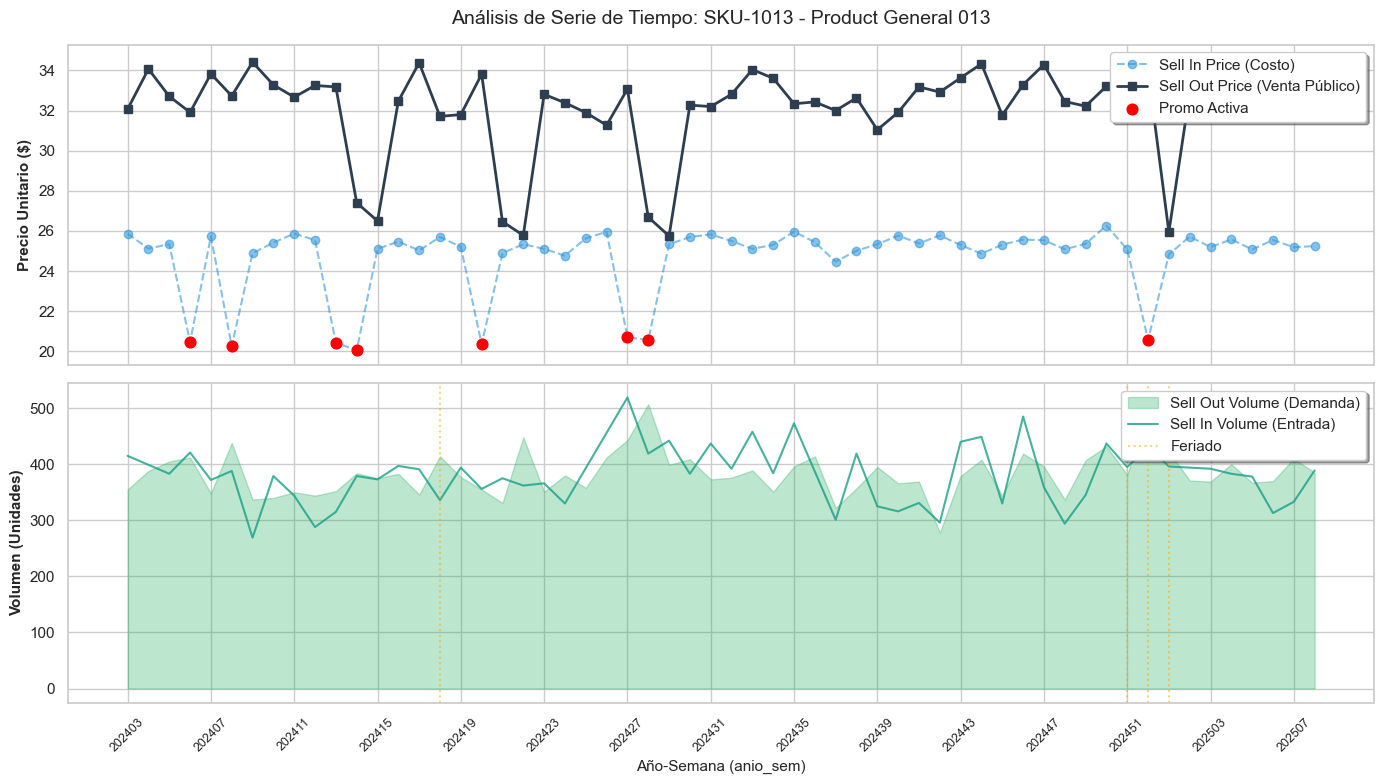

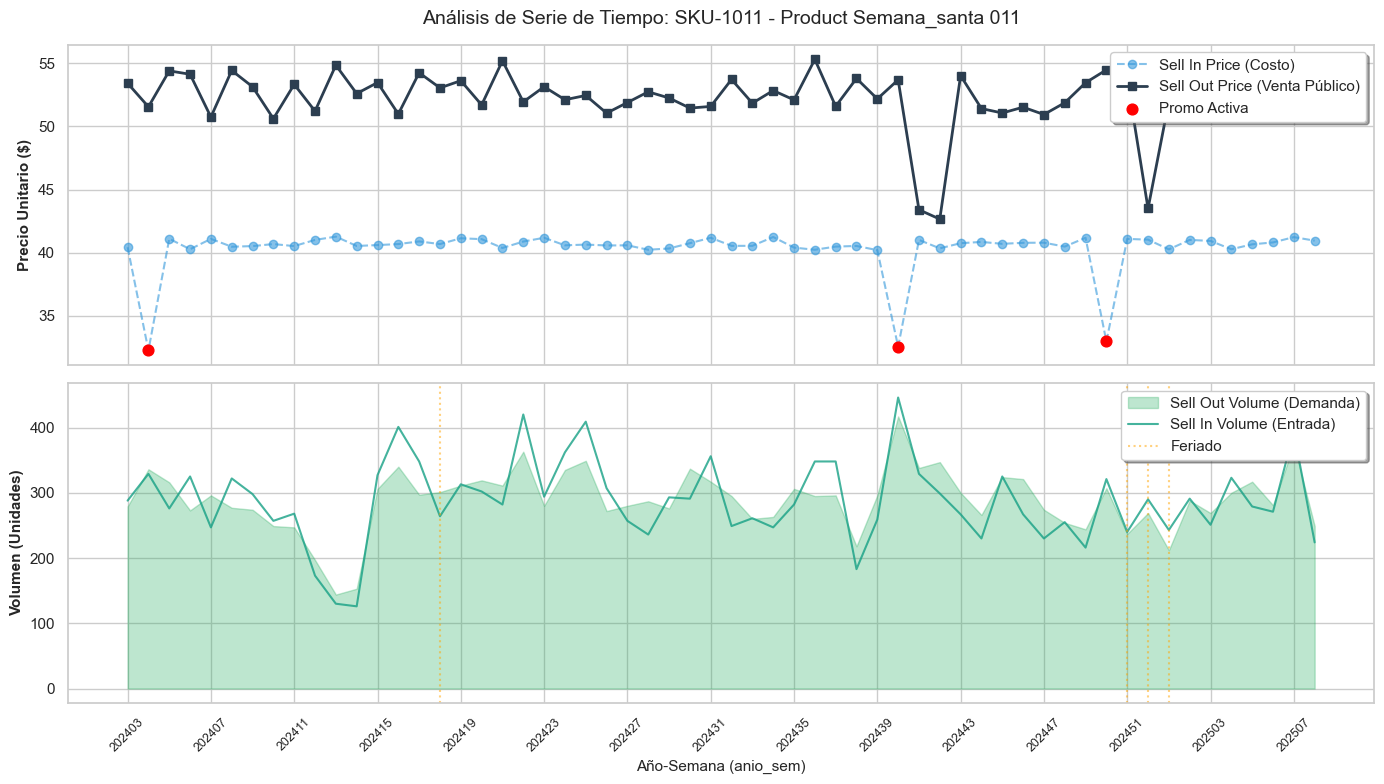

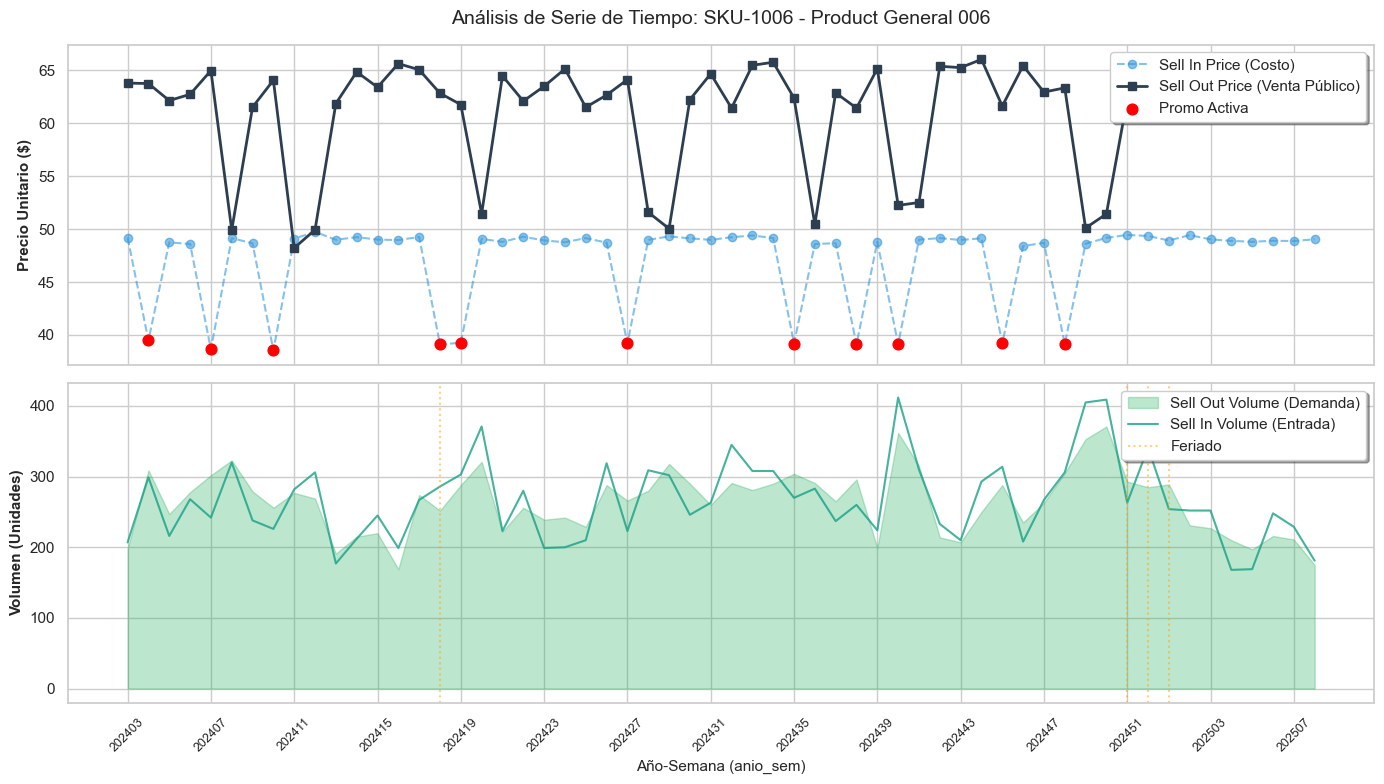

In [39]:
# Reviewing some SKUS radomly

N_SKUS = 3  # Number of SKUs to check


sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

# Selecting N SKUs randomly
random_skus = random.sample(list(df_final['sku'].unique()), N_SKUS)

def plot_sku_analysis(df, sku_list):
    for sku in sku_list:
        # Filtering and sorting by time
        sku_data = df[df['sku'] == sku].sort_values('anio_sem').copy()
        item_name = sku_data['item'].iloc[0]
        
        # Creating a plot with two sub-plots sharing the X axis
        fig, (ax_p, ax_v) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, 
                                         gridspec_kw={'height_ratios': [1, 1]})
        
        # --- SUBPLOT 1: PRICES (Sell In vs Sell Out) ---
        ax_p.plot(sku_data['anio_sem'], sku_data['si_unit_price'], 'o--', 
                  label='Sell In Price (Costo)', color='#3498db', alpha=0.6)
        ax_p.plot(sku_data['anio_sem'], sku_data['so_unit_price'], 's-', 
                  label='Sell Out Price (Venta Público)', color='#2c3e50', linewidth=2)
        
        # Highlighting promotions with red dots
        promos = sku_data[sku_data['promo_flag'] == 1]
        ax_p.scatter(promos['anio_sem'], promos['si_unit_price'], 
                     color='red', label='Promo Activa', zorder=5, s=60)
        
        ax_p.set_ylabel('Precio Unitario ($)', fontsize=11, fontweight='bold')
        ax_p.set_title(f"Análisis de Serie de Tiempo: {sku} - {item_name}", fontsize=14, pad=15)
        ax_p.legend(loc='upper right', frameon=True, shadow=True)
        
        # --- SUBPLOT 2: VOLUMES (Real Volume vs FillRate) ---
        ax_v.fill_between(sku_data['anio_sem'], sku_data['so_volume'], 
                          alpha=0.3, color='#27ae60', label='Sell Out Volume (Demanda)')
        ax_v.plot(sku_data['anio_sem'], sku_data['si_volume'], 
                  color='#16a085', label='Sell In Volume (Entrada)', linewidth=1.5, alpha=0.8)
        
        # Highlighting holidays (Holiday Flag) at volume axis
        holidays = sku_data[sku_data['holiday_flag'] == 1]
        for h_date in holidays['anio_sem']:
            ax_v.axvline(x=h_date, color='orange', linestyle=':', alpha=0.5, label='Feriado' if h_date == holidays['anio_sem'].iloc[0] else "")

        ax_v.set_ylabel('Volumen (Unidades)', fontsize=11, fontweight='bold')
        ax_v.set_xlabel('Año-Semana (anio_sem)', fontsize=11)
        ax_v.legend(loc='upper right', frameon=True, shadow=True)

        # Adjusting X-Axis ticks to avoid saturation
        plt.xticks(rotation=45, fontsize=9)
        ax_v.xaxis.set_major_locator(plt.MaxNLocator(20)) 
        
        plt.tight_layout()
        plt.show()

print(f'Revisando {N_SKUS} SKUs al azar')

# Ejecutar la función
plot_sku_analysis(df_final, random_skus)

In [40]:
# Saving Output file to CSV
#  
df_final.to_csv('../inputs/fake_db_input.csv',
                index=False)

Revisando 3 SKUs al azar


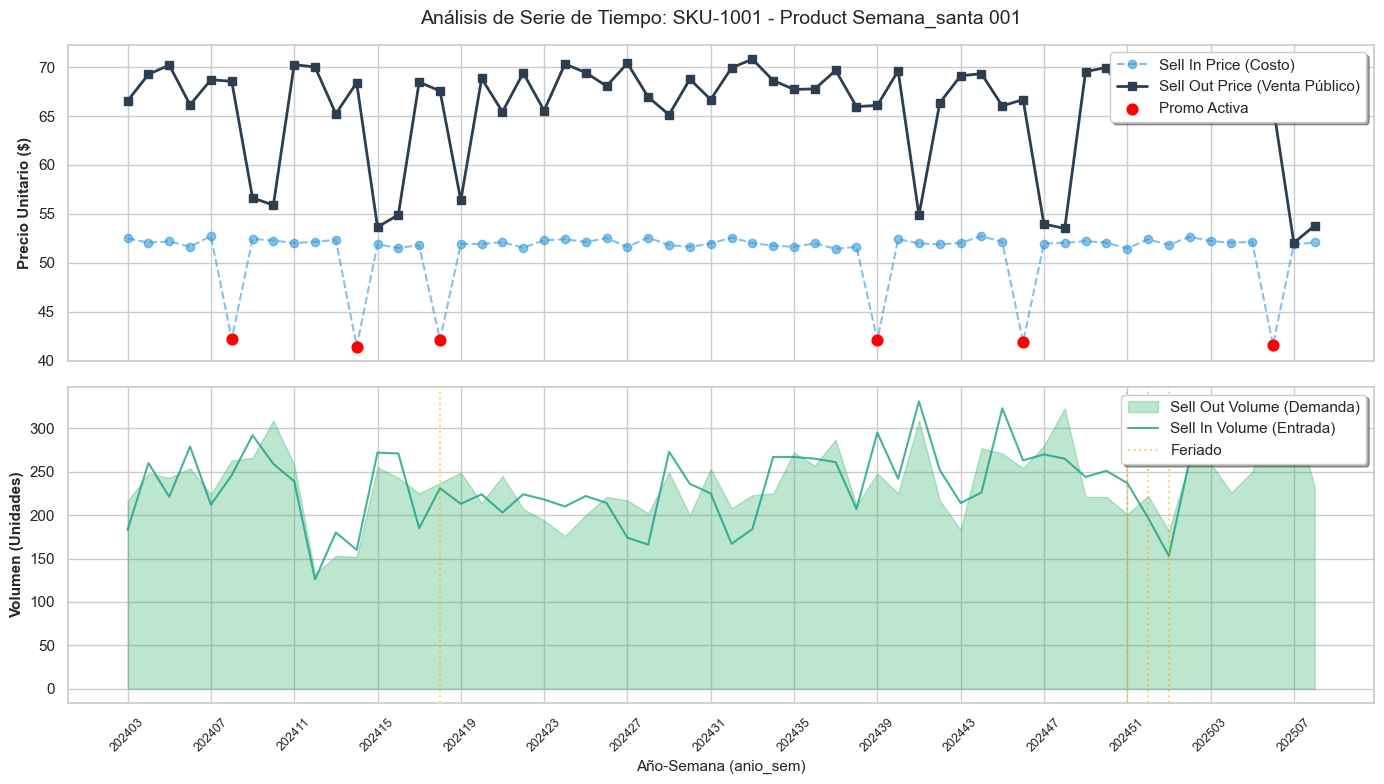

In [41]:
# Analizing especific cases

# Selecting codes to check
random_skus = ['SKU-1001']


print(f'Revisando {N_SKUS} SKUs al azar')

# Ejecutar la función
plot_sku_analysis(df_final, random_skus)